In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
from utils.data_loader import load_data
import warnings
warnings.filterwarnings("ignore")

df, config, features = load_data()


In [17]:
def prediction_data_pruner(df, threshold=0):
    """Remove data rows based on the threshold of missing values."""
    data = df
    mandatory_columns = ['Fibrinogen_g_L', 'LDH_UI_L', 'WBC_G_L', 'Lymphocytes_G_L',
    'MCHC_g_L', 'MCV_fL', 'Monocytes_G_L', 'Platelets_G_L',
    'PT_percent']
    
    ['MCV_fL', 'PT_percent', 'LDH_UI_L', 'MCHC_g_L', 'WBC_G_L', 'Fibrinogen_g_L', 'Monocytes_G_L', 'Platelets_G_L', 'Lymphocytes_G_L']

    data["nan_percentage"] = data[mandatory_columns].isna().mean(axis=1)

    # Prune data where the percentage of NaN values is above the threshold
    data = data[data["nan_percentage"] <= threshold]
    data.drop(columns=["nan_percentage"], inplace=True)
    return data


def get_confusion_matrix(df, ax, title, do_normalize='true', min_samples=10):
    df = df.copy()
    
    # Check if we have enough samples
    if len(df) < min_samples:
        ax.text(0.5, 0.5, f'Insufficient samples\n(n={len(df)})', 
                ha='center', va='center')
        ax.set_title(title)
        return
    
    # Convert prediction columns to float
    df[["prediction.ALL", "prediction.AML", "prediction.APL"]] = df[["prediction.ALL", "prediction.AML", "prediction.APL"]].astype(float)

    if not title == 'Antananarivo':
        df = prediction_data_pruner(df, threshold=0.2)
    
    # Check if we still have samples after pruning
    if len(df) == 0:
        ax.text(0.5, 0.5, 'No samples after pruning', 
                ha='center', va='center')
        ax.set_title(title)
        return

    # Get the predicted class by finding the column name with max value
    max_pred_cols = df[["prediction.ALL", "prediction.AML", "prediction.APL"]].idxmax(axis=1)
    df["max_pred"] = max_pred_cols.apply(lambda x: x.split(".")[1])
    
    cm_display = ConfusionMatrixDisplay.from_predictions(df["class"], df["max_pred"], 
                                                       ax=ax, colorbar=False, 
                                                       normalize=do_normalize)
    ax.set_title(f"{title}\n(n={len(df)})")

size of Dallas: 284
size of Melbourne: 354
size of Maastricht: 242
size of Barcelona: 137
size of Bochum: 72
size of Wroclaw: 181
size of Kolkata: 110
size of Rome: 115
size of Salamanca: 197
size of Sao paulo: 324
size of Buenos aires: 115
size of Milano: 135
size of Suzhou: 1195
size of Antananarivo: 81
size of Hannover: 644
size of Lagos: 33


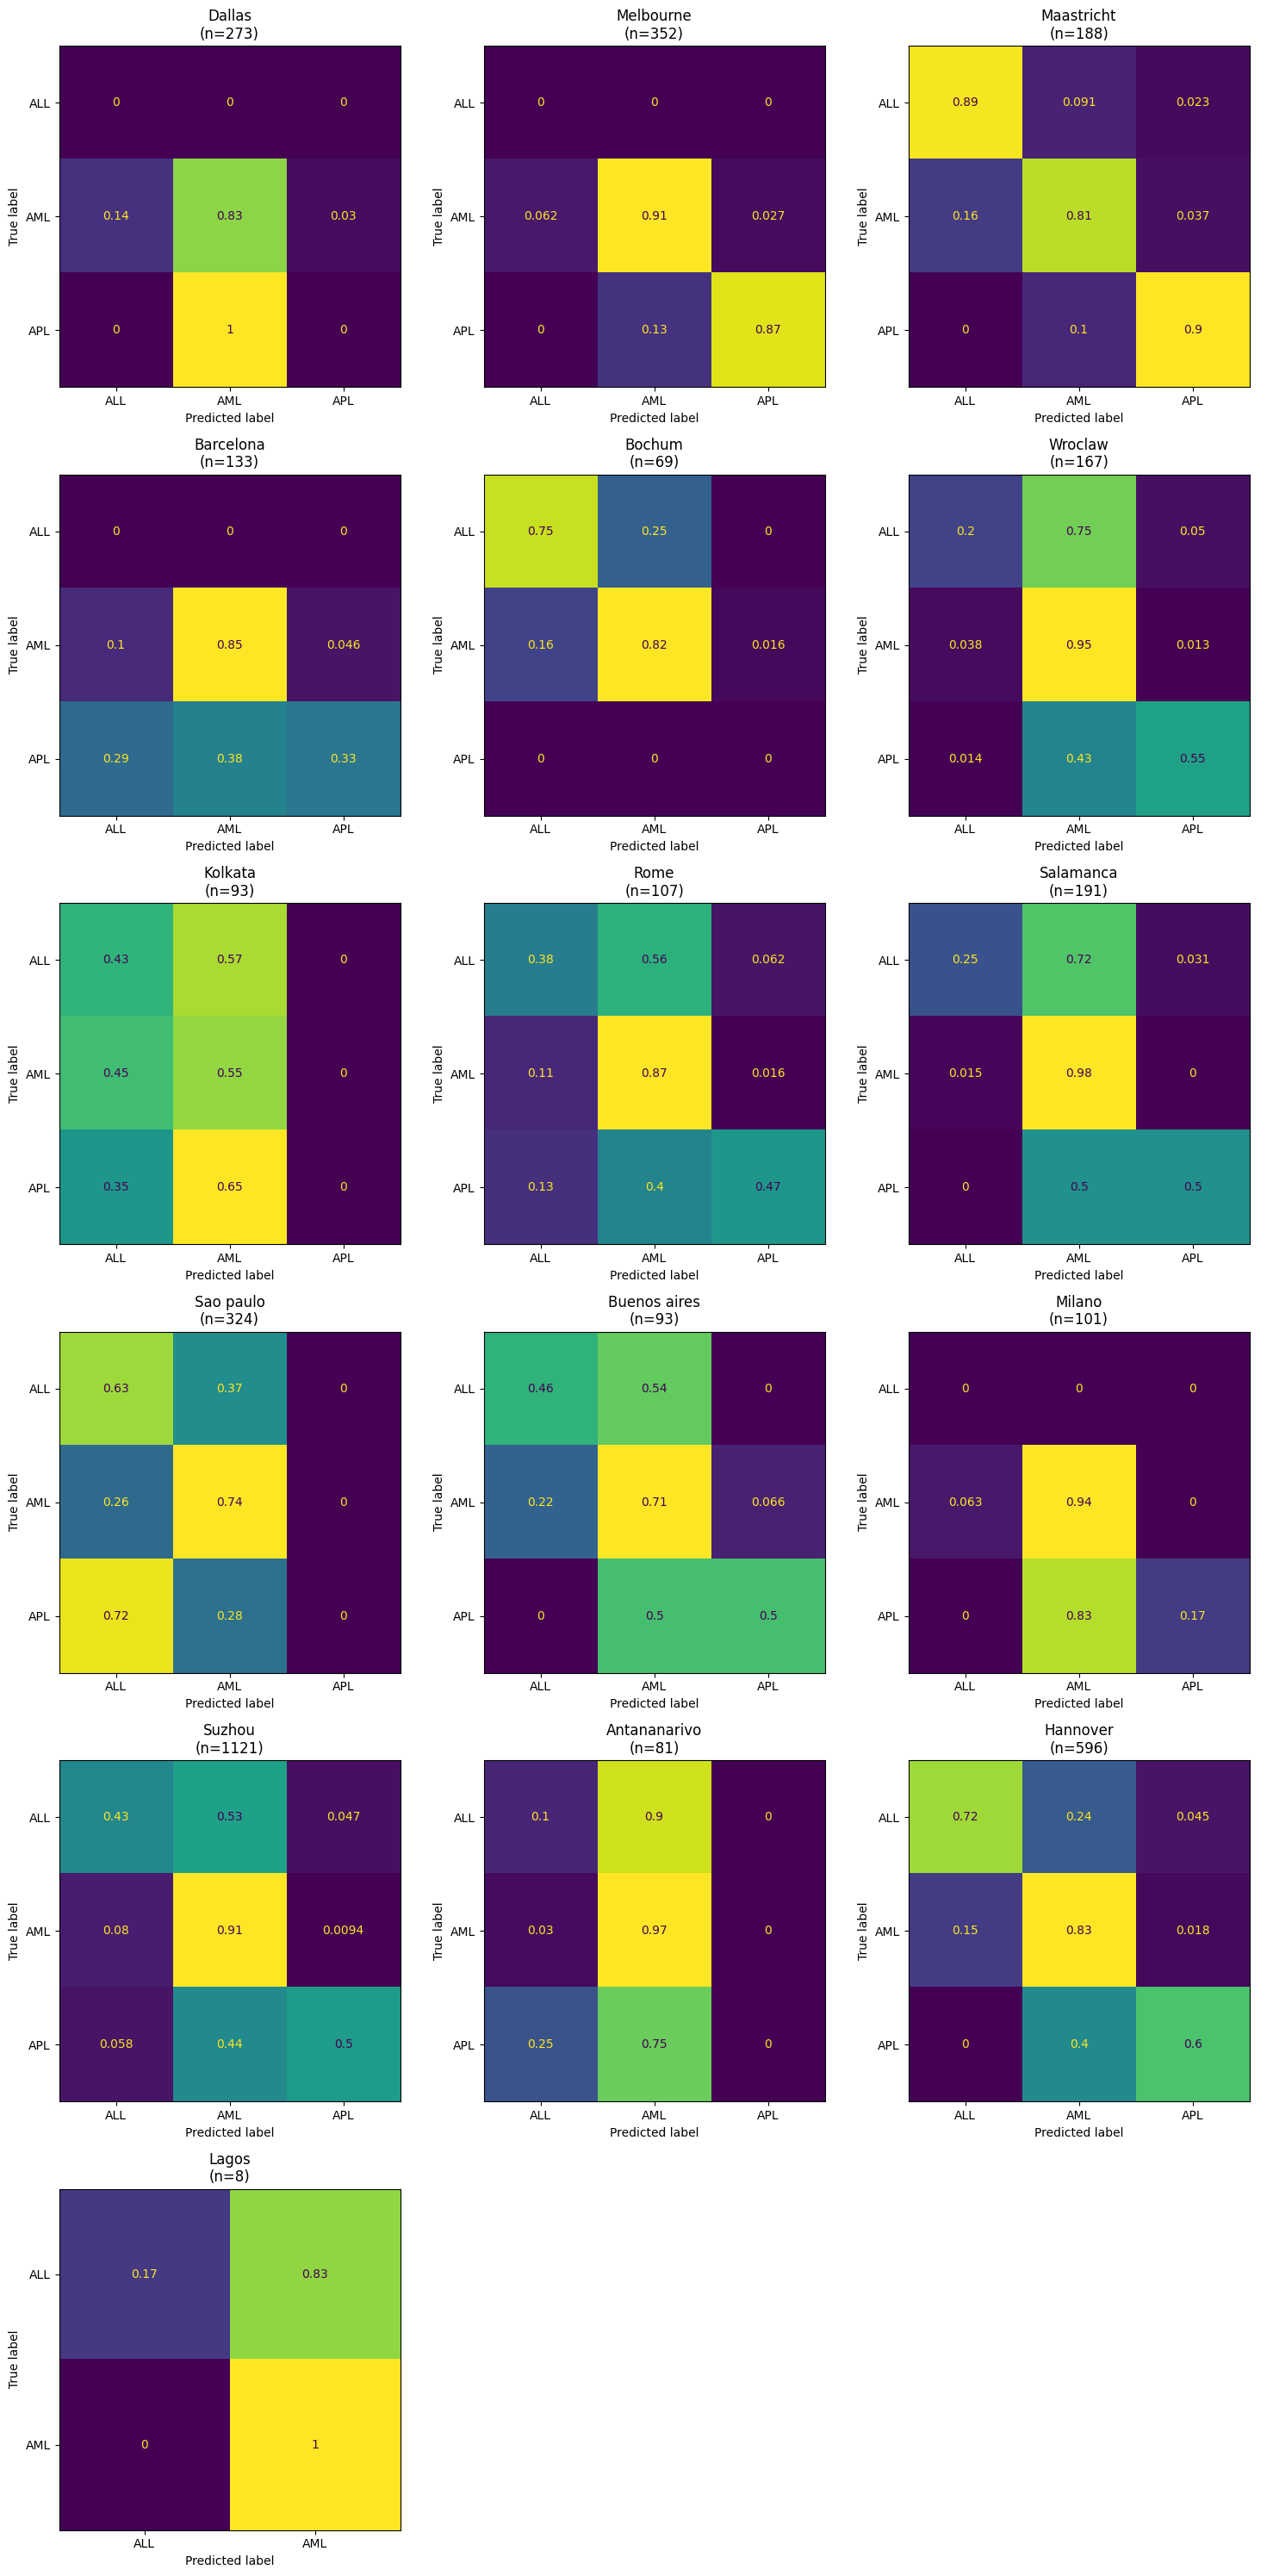

In [18]:
import matplotlib.pyplot as plt

# Create the figure with subplots
n_cities = df['city_country'].nunique()
n_rows = (n_cities + 2) // 3  # Calculate rows needed for 3 columns
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, city_country in enumerate(df['city_country'].unique()):
    df_small = df[df['city_country'] == city_country]
    print(f"size of {city_country}: {df_small.shape[0]}")
    get_confusion_matrix(df_small, axes[i], title=city_country)


# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

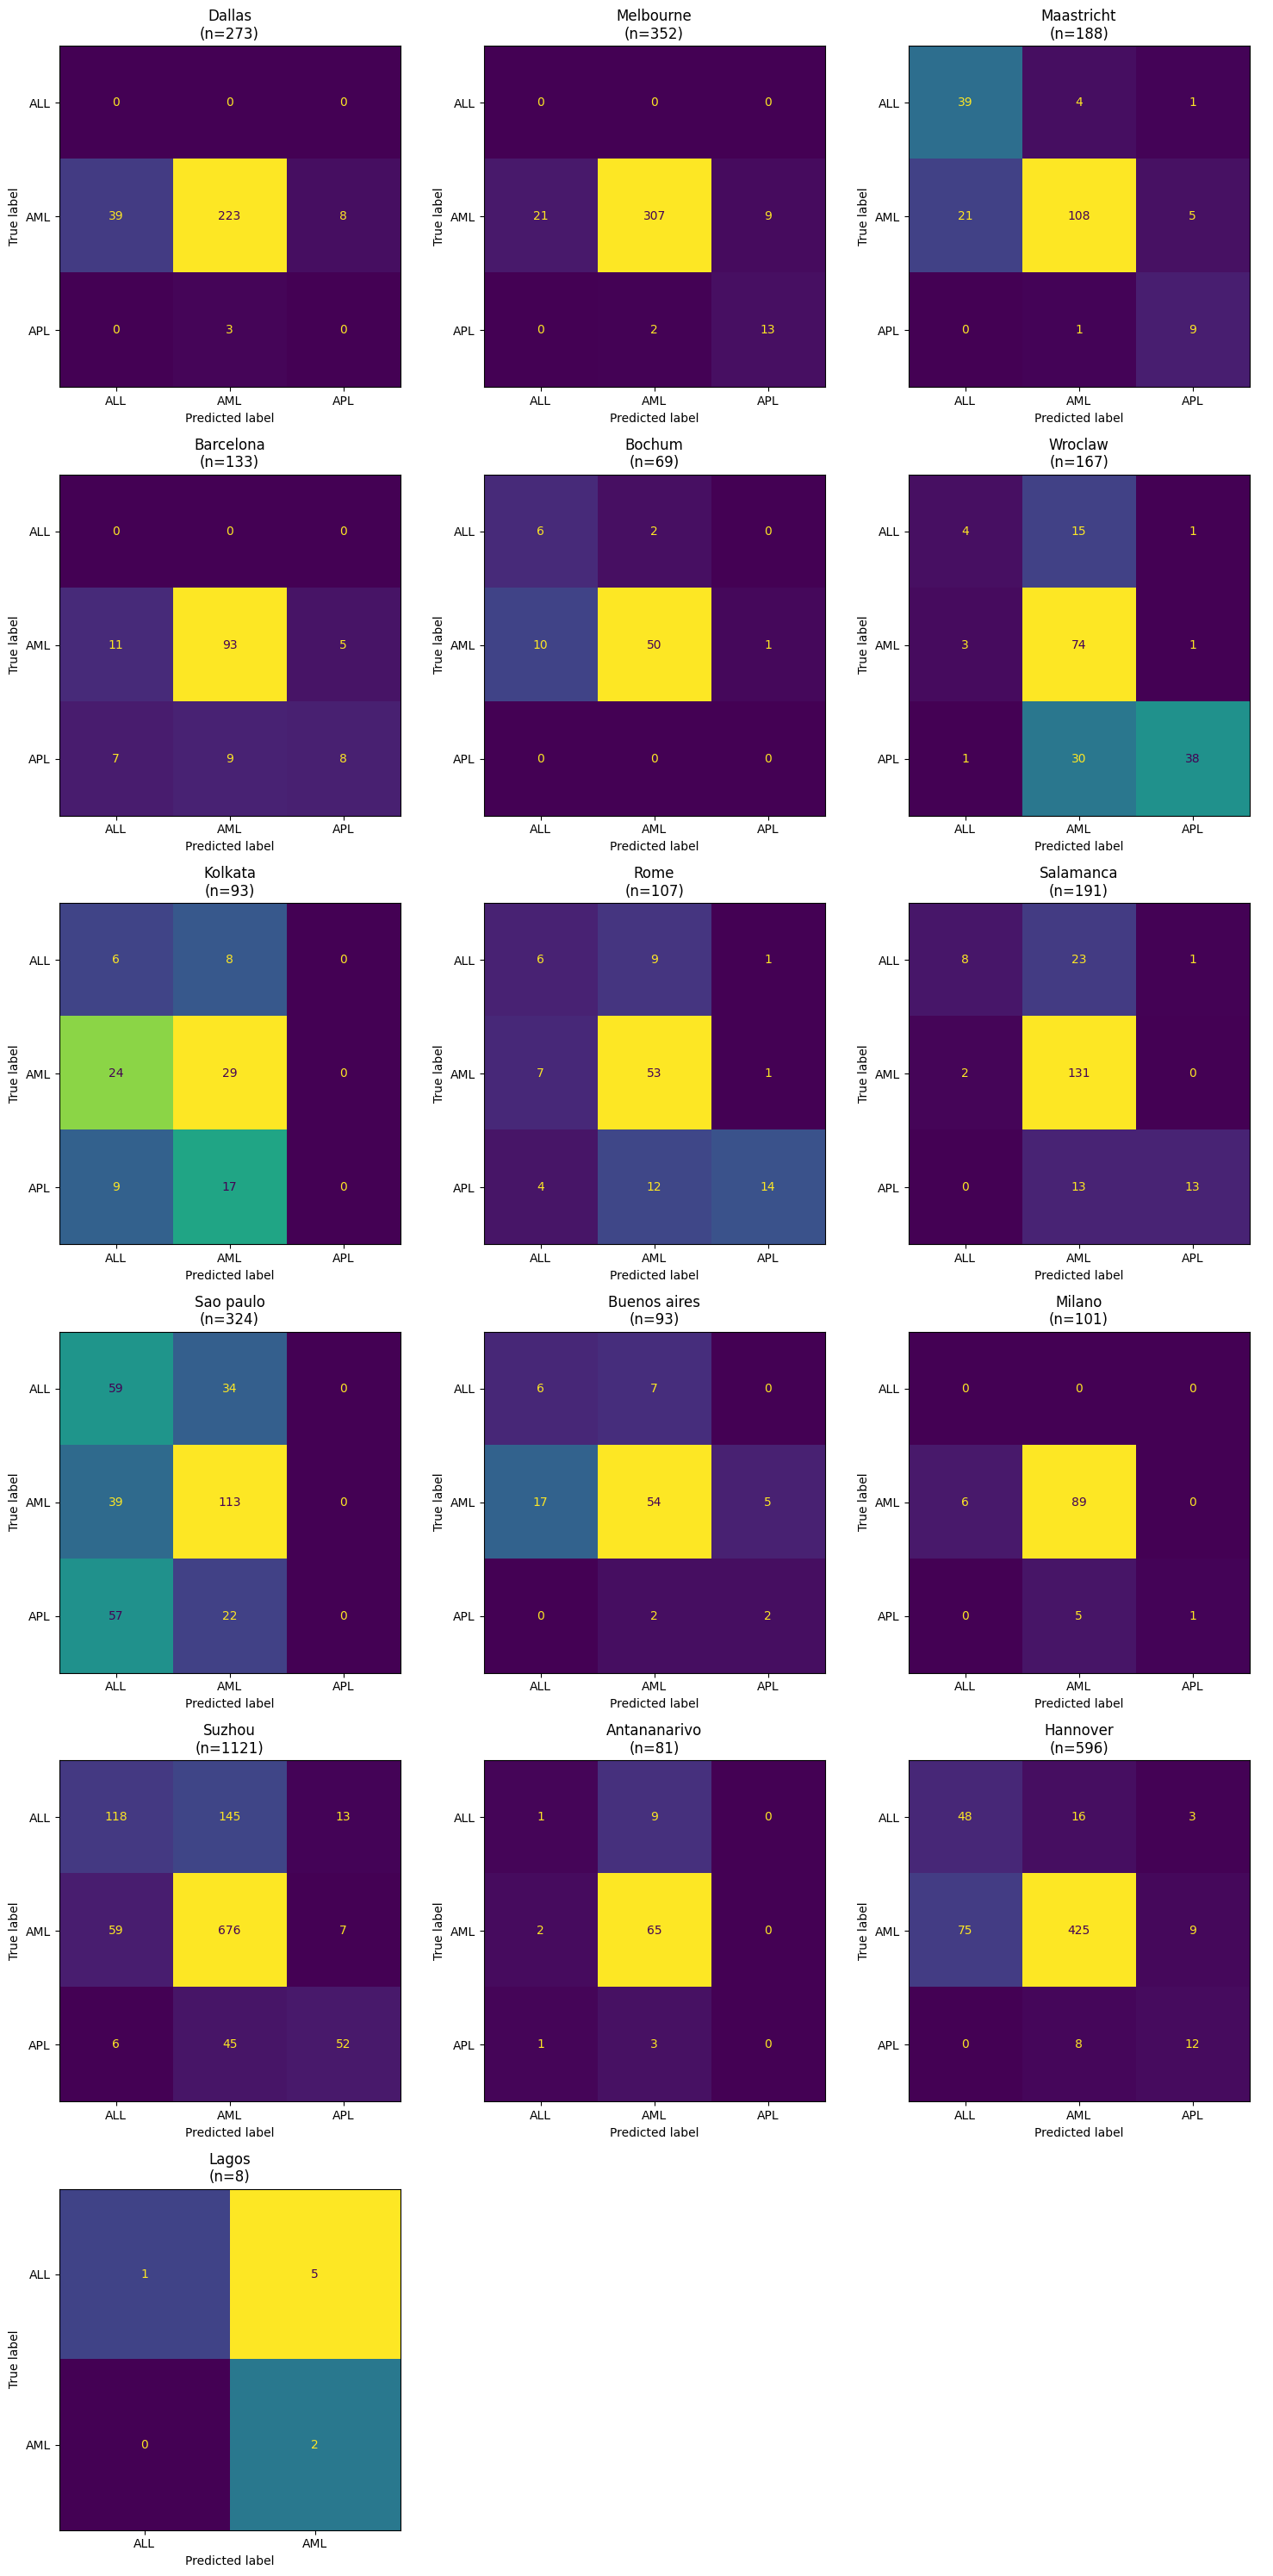

In [19]:
import matplotlib.pyplot as plt

# Create the figure with subplots
n_cities = df['city_country'].nunique()
# filter country with less than 10 samples
n_rows = (n_cities + 2) // 3  # Calculate rows needed for 3 columns
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, city_country in enumerate(df['city_country'].unique()):
    df_small = df[df['city_country'] == city_country]
    get_confusion_matrix(df_small, axes[i], title=city_country, do_normalize=None)

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

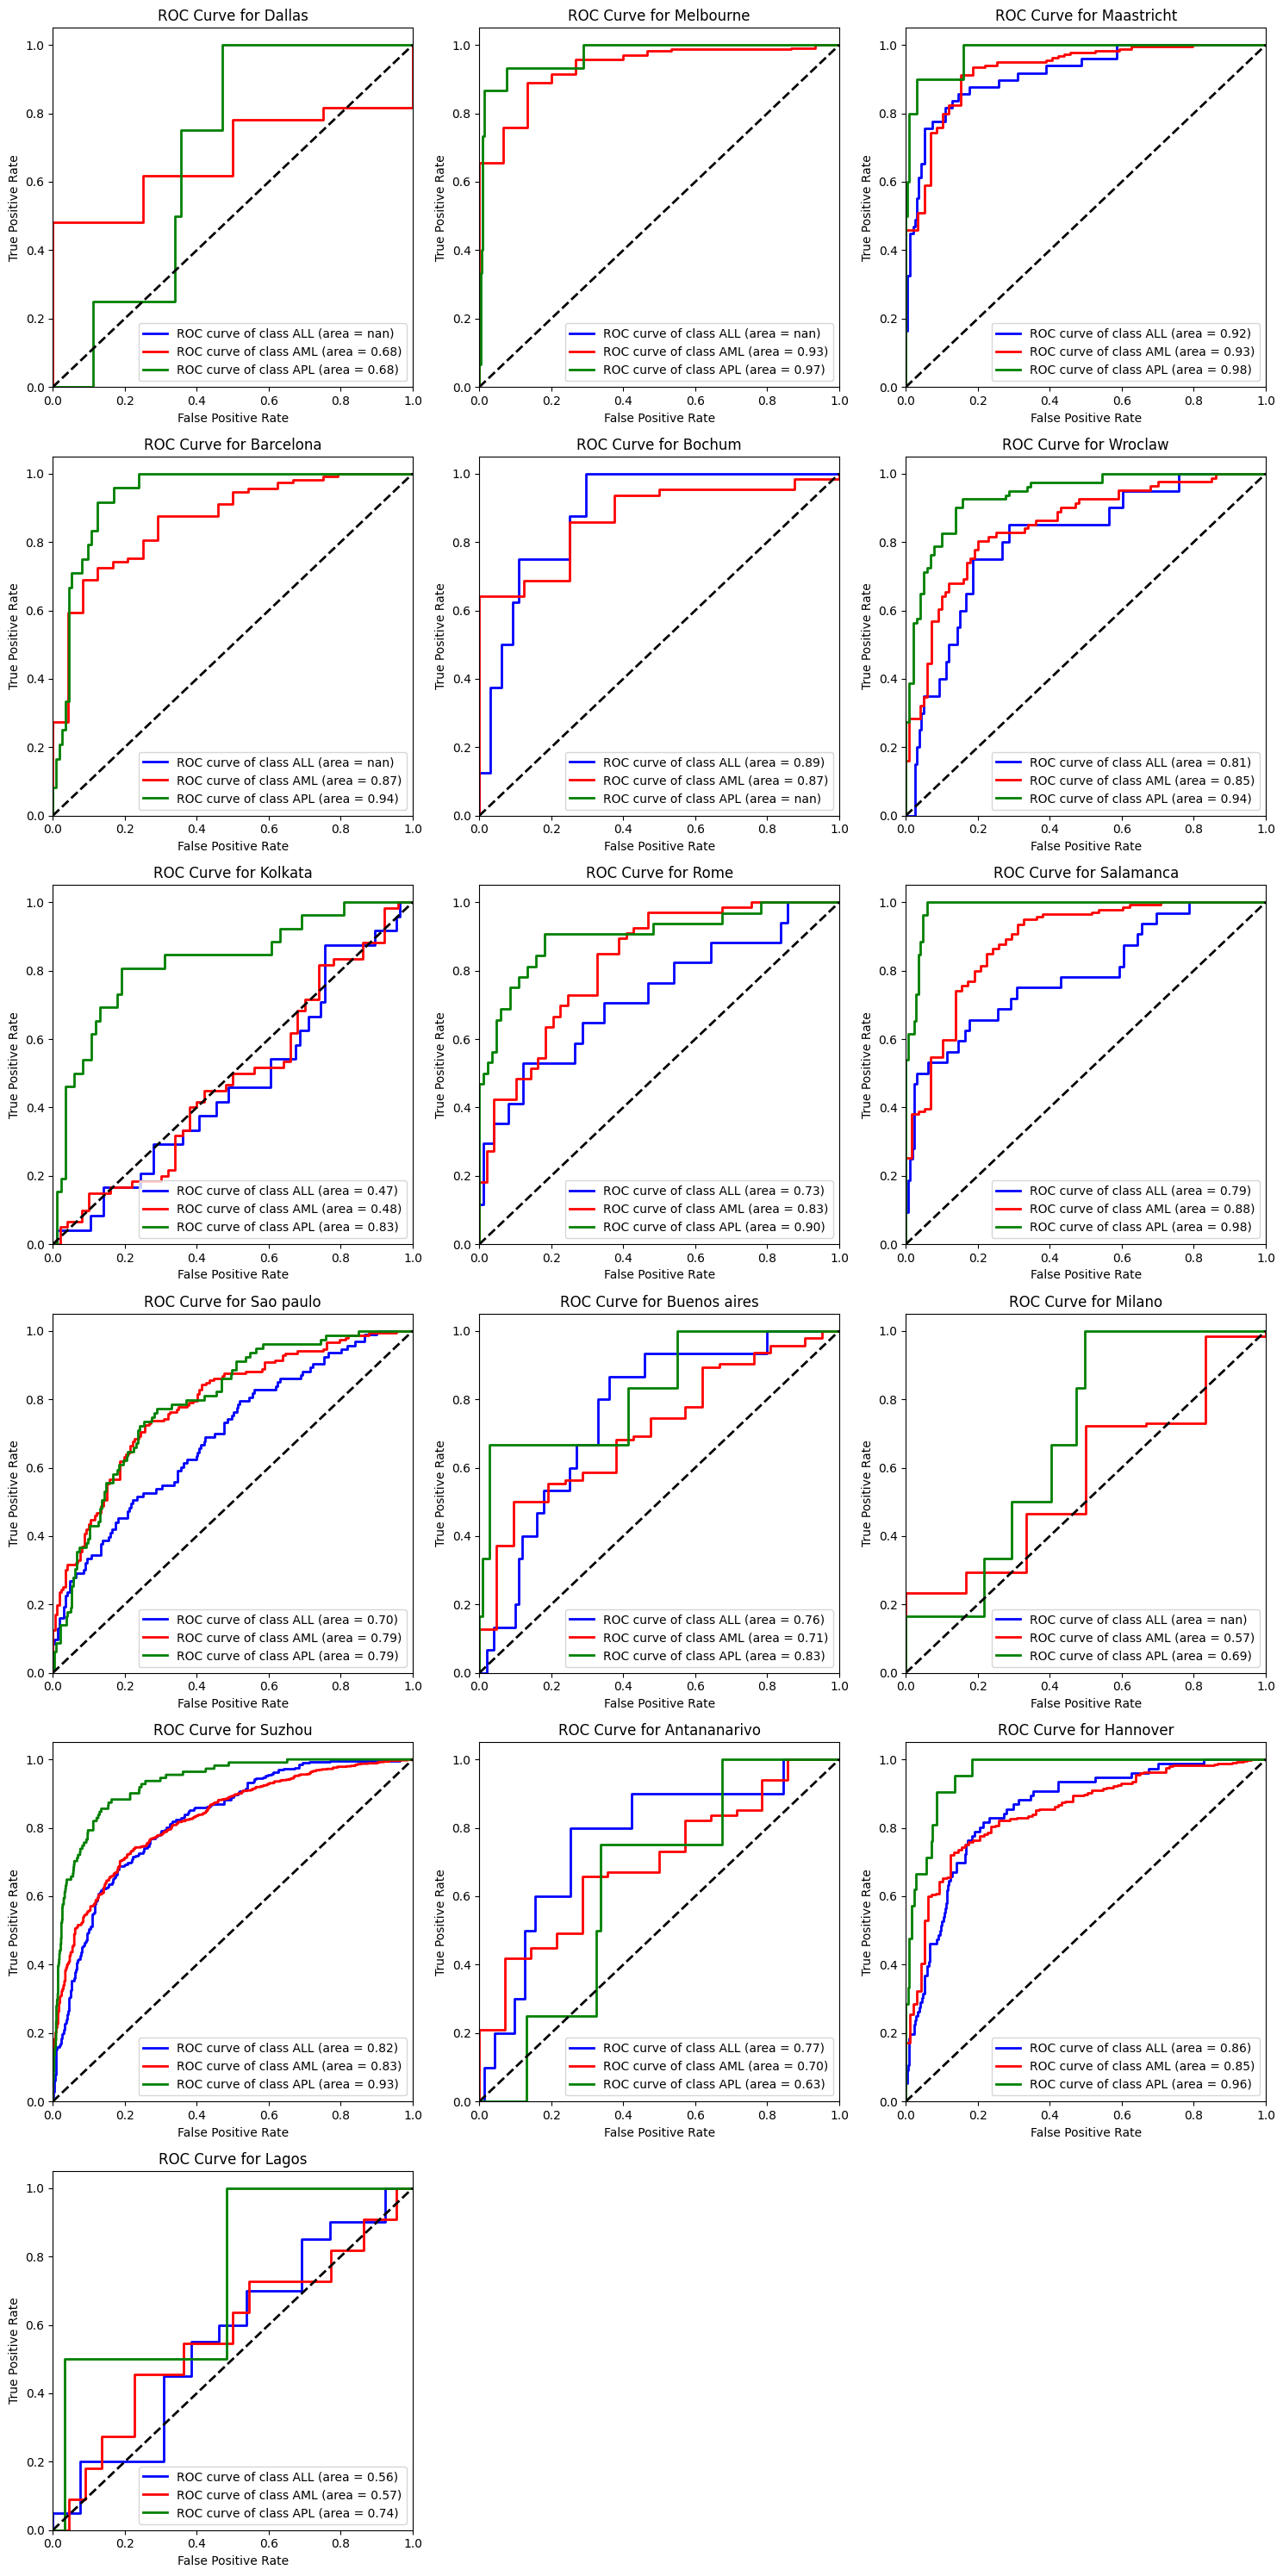

In [20]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Create the figure with subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, city_country in enumerate(df['city_country'].unique()):
    df_small = df[df['city_country'] == city_country].copy()
    df_small[["prediction.ALL", "prediction.AML", "prediction.APL"]] = df_small[["prediction.ALL", "prediction.AML", "prediction.APL"]].astype(float)

    # Binarize the class labels
    classes = ["ALL", "AML", "APL"]
    y = label_binarize(df_small['class'], classes=classes)
    n_classes = y.shape[1]

    # Convert predictions to a similar format for ROC calculation
    y_score = df_small[["prediction.ALL", "prediction.AML", "prediction.APL"]].values

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y[:, j], y_score[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Plot all ROC curves
    ax = axes[i]
    colors = ['blue', 'red', 'green']
    for j, color in zip(range(n_classes), colors):
        ax.plot(fpr[j], tpr[j], color=color, lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(classes[j], roc_auc[j]))

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {city_country}')
    ax.legend(loc="lower right")

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()